## KoBert 설치 및 필요한 라이브러리 가져오기

In [13]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!git clone https://github.com/SKTBrain/KoBERT.git
!pip install -r /content/KoBERT/requirements.txt

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-ajshl1dn
  Running command git clone --filter=blob:none -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-ajshl1dn
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 5c46b1c68e4755b54879431bd302db621f4d2f47
  Preparing metadata (setup.py) ... done
fatal: destination path 'KoBERT' already exists and is not an empty directory.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/KoBERT/requirements.txt'


In [14]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [16]:
## CPU
# device = torch.device("cpu")

# GPU
device = torch.device("cuda:0")

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# Set Korean font (e.g., Malgun Gothic for Windows)
rc('font', family='Malgun Gothic')

# Prevent minus sign issues
plt.rcParams['axes.unicode_minus'] = False

In [21]:
import os
os.getcwd() 

'/aiffel/aiffel/dktc'

## 데이터 불러오기 및 전처리

In [22]:
# 파일의 경로
train_dir = os.getcwd() + '/data/train.csv'
general_dir = os.getcwd() + '/general_conversations.csv'

In [23]:
# 파일 불러오기
train = pd.read_csv(train_dir)
general = pd.read_csv(general_dir)

In [24]:
general.head(10)

,class,conversation
0,일반,너 저번에 갯벌 체험 다녀왔다며? 어땠어? 응 정말 재밌었어 게랑 조개도 잡고 다양...
1,일반,물고기 키우는 거 좋아하지? 응 근데 요즘 수족관 관리가 힘들어. 왜? 뭐가 문제야...
2,일반,요즘 로컬푸드 많이 사 먹는다면서? 응 근처 직거래 장터에서 사. 어때? 신선하고 ...
3,일반,이번에 제주도 가서 성산일출봉 봤어? 응 일출 보러 갔었어. 어땠어? 장관이더라. ...
4,일반,"산책하다가 다친 새를 본 적 있어? 응, 예전에 날개 다친 참새를 본 적 있어. 어..."
5,일반,"너네 집 화분 잘 크고 있어? 아니, 나 키우던 허브 다 죽었어. 어떻게 관리했는데..."
6,일반,요즘 친환경 화장품 쓴다면서? 응 플라스틱 용기 줄이려고. 효과는 어때? 피부에 자...
7,일반,여보 우리 집 앞 가로수가 요즘 예쁘게 피었더라구요. 맞아요 벚꽃이 만개해서 정말 ...
8,일반,요즘 도시농업이 뜨고 있다면서? 응 맞아. 베란다나 옥상에서 채소를 기르는 사람들이...
9,일반,요즘 채식하는 사람들이 많더라. 너는 어떻게 생각해? 나도 채식 좀 해보려고 해 건...


In [25]:
# 인덱스 칼럼 제거
train.drop(columns='idx', inplace=True, axis=1)

In [26]:
train.head()

,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [27]:
# 두 데이터 프레임 합치기
combined = pd.concat([train, general])
combined.drop_duplicates(inplace=True)

In [28]:
combined['class'].unique()

array(['협박 대화', '기타 괴롭힘 대화', '갈취 대화', '직장 내 괴롭힘 대화', '일반'], dtype=object)

In [29]:
combined.groupby('class').size()

class
갈취 대화          1946
기타 괴롭힘 대화      2022
일반              696
직장 내 괴롭힘 대화    1940
협박 대화          1784
dtype: int64

In [30]:
# 클래스 값을 label로 매핑하기
mapping_dict = {
"일반": 0,
"갈취 대화": 1,     
"기타 괴롭힘 대화": 2,
"직장 내 괴롭힘 대화" : 3,
"협박 대화": 4       
}

combined['label'] = combined['class']
combined.replace({'label': mapping_dict}, inplace=True)
combined['label'] = combined['label'].astype('category')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distribution')

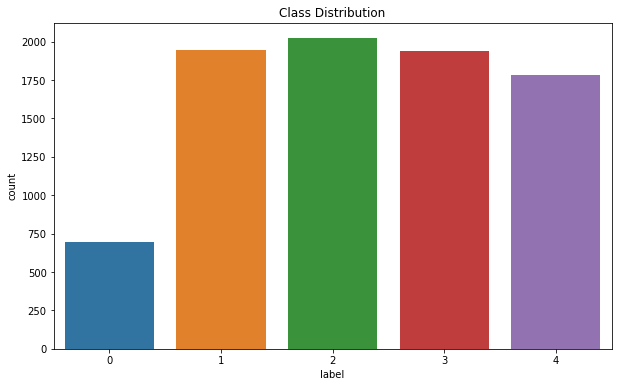

In [38]:
plt.figure(figsize=(10, 6))
sns.countplot(combined['label'])
plt.title('Class Distribution')

In [39]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8388 entries, 0 to 4665
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   class         8388 non-null   object  
 1   conversation  8388 non-null   object  
 2   label         8388 non-null   category
dtypes: category(1), object(2)
memory usage: 463.0+ KB


In [40]:
# 매핑 후 class는 삭제한다.
combined.drop(columns='class', inplace=True, axis=1)

In [43]:
combined.sample(10)

,conversation,label
914,좀전에 통화한 사람인데요!\n네네. 고객님\n어떻게할거예요? 알려준대로 했는데 안되...,2
3574,너 상대를 잘못 골랐어\r\n하 웃기고 있네\r\n과연 니가 가족도 내팽개치고 할 ...,4
3253,아침에 전화를 받지 말든지 받았으면 제대로 해결을 하든지\r\n죄송합니다\r\n전달...,3
4509,자꾸 내 돈 안 갚고 어딜 도망가?\r\n기간을 조금만 더 주시면.이율이 너무.\r...,4
3289,자네는 왜 아까부터 술을 안마시나?\r\n앗. 죄송합니다. 제가 간이 안좋아서 현재...,3
4385,좋게 좋게 말 하니까 내 말이 우스워?\r\n그런거 아니야.\r\n그런게 아니야? ...,4
3241,혜정아 지금 빨리 인스타에 우리 같이 찍은 사진 올려.\n오빠 그건 내 계정이고 내...,4
3811,우리 채영이가 발표해볼까?\r\n .네. 저의 꿈은 의사입니다.\r\n선생님 안들려...,2
1918,박인턴\n죄송합니다. 이 작업만 하고 곧 가겠습니다.\n상사 말이 말같지 않지? 빨...,3
641,체크인을 하려고 하는데요.\n 성함과 예약 번호를 알려주시겠어요?\n 제 이름은 ...,0


## KoBert 로 분류 준비하기

In [45]:
bertmodel, vocab = get_pytorch_kobert_model()

/aiffel/aiffel/dktc/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/aiffel/aiffel/dktc/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [46]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /aiffel/aiffel/dktc/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
# 이거 바꾸어야 하나?

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

## 생각 정리

In [47]:
"""
    일단 bert 살펴보기

    토큰화 해야하는지
    좀 더 생각해볼만 한 것들:
    각 클래스 별로 문장을 토크나이즈 하여 토큰의 분포 살펴보면 좋을 듯
    쓸모 없는 토큰들을 찾아서 불용어 사전을 만들어볼까
    
"""

'\n    일단 bert 살펴보기\n\n    토큰화 해야하는지\n    좀 더 생각해볼만 한 것들:\n    각 클래스 별로 문장을 토크나이즈 하여 토큰의 분포 살펴보면 좋을 듯\n    쓸모 없는 토큰들을 찾아서 불용어 사전을 만들어볼까\n    \n'